In [162]:
import cv2
import numpy as np
from common import CV_DATASETS_DIR
from pathlib import Path
from PIL import Image

face_cascade = cv2.CascadeClassifier('/usr/share/opencv4/haarcascades/haarcascade_frontalface_alt.xml')
assert  not face_cascade.empty()

def get_image_data(path: Path) -> ([np.array], [int]):
    images = []
    labels = []
    files = path.glob('*.gif')
    for file in files:
        images.append(np.array(Image.open(file).convert('L'), 'uint8'))
        labels.append(int(file.stem.split('.')[0].replace('subject', '')))
    return images, np.array(labels)

def preprocess_image_data(in_images: [np.array], padding: int = 5, kernel: int = 7, sigma: float = 0.0) -> [np.array]:
    out_images = []
    for image in in_images:
        faces = face_cascade.detectMultiScale(image, scaleFactor=1.1, minNeighbors=5)
        for (x, y, w, h) in faces:
            # Crop image
            image = image[y - padding + 1 : y + h + padding, x - padding + 1 : x + w + padding]
            # Remove noise
            cv2.GaussianBlur(image, [kernel, kernel], 0, image, sigma, cv2.BORDER_DEFAULT)
            # Equalize histogram
            cv2.equalizeHist(image, image)           
        out_images.append(image)
    return out_images

train_images, train_labels = get_image_data(CV_DATASETS_DIR / 'images' / 'yalefaces' / 'train')
train_images = preprocess_image_data(train_images)


In [163]:
# Train and save classifier
from common import CV_WORKAREA_DIR
classifier1 = cv2.face.LBPHFaceRecognizer.create()
classifier1.train(train_images, train_labels)
classifier1.write(str(CV_WORKAREA_DIR / 'lbph_classifier.yml'))

In [164]:
# Load classifier and recognize faces
classifier2 = cv2.face.LBPHFaceRecognizer.create()
classifier2.read(str(CV_WORKAREA_DIR / 'lbph_classifier.yml'))

predictions = []
expected = []
test_images, test_labels = get_image_data(CV_DATASETS_DIR / 'images' / 'yalefaces' / 'test')
test_images = preprocess_image_data(test_images)
for image, label in zip(test_images, test_labels):
    predict, confidence = classifier2.predict(image)
    predictions.append(predict)
    expected.append(label)

predictions = np.array(predictions)
expected = np.array(expected)


Accuracy: 90.0%


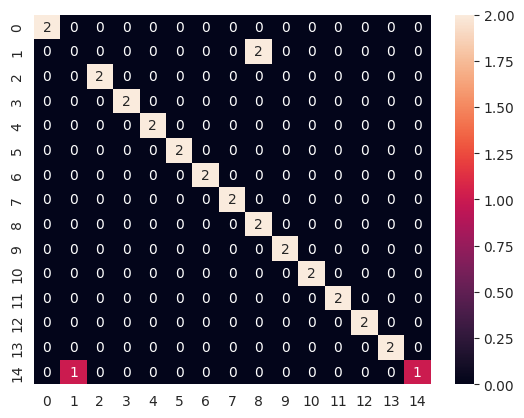

In [165]:
# Evaluate recognizing result
import seaborn
from sklearn.metrics import accuracy_score, confusion_matrix

accuracy = accuracy_score(expected, predictions)
print(f'Accuracy: {accuracy * 100:.3}%')

cm = confusion_matrix(expected, predictions)
seaborn.heatmap(cm, annot=True);
